In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from os.path import join
from matplotlib.colors import LinearSegmentedColormap
from seaborn.palettes import color_palette
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [121]:
DATA_FOLDER = 'data'
RESULTS_FOLDER = 'results'
QUESTIONNAIRE = 'QuestionnaireData.csv'
MUSIC_TASK = 'MusicPreferenceTask'
PF_TASK = 'PerceptualFluencyTask'
GAMBLING_TASK = 'GamblingTask'
ACROSS_TASKS = 'AcrossTasks'

# 1. Music Preference Task

In [87]:
num_participants = 164
remove_ids = [23, 28, 143, 151, 152, 97, 105, 117]

subject_ids = [i for i in range(1, num_participants + 1) if i not in remove_ids]

In [88]:
questionnaire_data = pd.read_csv(f'{DATA_FOLDER}/{QUESTIONNAIRE}')
questionnaire_data = questionnaire_data[~questionnaire_data['subj'].isin(remove_ids)]
questionnaire_data.reset_index(drop=True, inplace=True)
questionnaire_data.shape

(156, 17)

In [89]:
music_data = pd.DataFrame()

for subject_id in subject_ids:
    file_name = f"music_ppn{'0' + str(subject_id) if subject_id < 10 else str(subject_id)}.rtd"
    file_path = join(DATA_FOLDER, MUSIC_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep="\t", header=0)
    music_data = pd.concat([music_data, temp_df], ignore_index=True)
music_data.shape

(17160, 27)

In [90]:
# Add a new column for preference prediction
music_data['pref_pred'] = np.where((music_data['s1.entclass'] > music_data['s2.entclass']) & (music_data['r'] == 1), 0,
                                        np.where((music_data['s1.entclass'] < music_data['s2.entclass']) & (music_data['r'] == 2), 0, 
                                                 np.where((music_data['s1.entclass'] > music_data['s2.entclass']) & (music_data['r'] == 2), 1, 
                                                          np.where((music_data['s1.entclass'] < music_data['s2.entclass']) & (music_data['r'] == 1), 1, np.nan))))

In [91]:
# Initialize music_preference DataFrame
columns = ['ppnr'] + [f'class{i}' for i in range(1, 12)] + ['weighted_sum', 'pref_pred']
music_preference = pd.DataFrame(columns=columns)
music_preference['ppnr'] = subject_ids

# Populate the music_preference DataFrame
for subject_id in subject_ids:
    subject_data = music_data[music_data['ppnr'] == subject_id]
    for i in range(1, 12):
        music_preference.loc[music_preference['ppnr'] == subject_id, f'class{i}'] = len(subject_data[(subject_data['r'] == 1) & (subject_data['s1.entclass'] == i)]) + len(subject_data[(subject_data['r'] == 2) & (subject_data['s2.entclass'] == i)])
    
    music_preference.loc[music_preference['ppnr'] == subject_id, 'weighted_sum'] = sum(music_preference.loc[music_preference['ppnr'] == subject_id, f'class{i}'] * (12-i) for i in range(1, 12))
    music_preference.loc[music_preference['ppnr'] == subject_id, 'pref_pred'] = subject_data['pref_pred'].mean()

In [92]:
extra = pd.DataFrame({
    "ppnr": [23, 28, 143, 151, 152],
    **{col: [np.nan] * 5 for col in columns if col != 'ppnr'}
})
music_preference = pd.concat([music_preference, extra], ignore_index=True).sort_values(by='ppnr').reset_index(drop=True)

# 2. Perceptual Fluency Task

In [93]:
n = 164
remove = [97, 105, 117]  # Participants with inconsistent scores
subject_list = [x for x in range(1, n + 1) if x not in remove]

In [94]:
fluency_data = pd.DataFrame()
for subject_id in subject_list:
    file_name = f"fluency_ppn{'0' + str(subject_id) if subject_id < 10 else subject_id}.rtd"
    file_path = join(DATA_FOLDER, PF_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep='\t', header=0)  # Assuming tab-separated values
    fluency_data = pd.concat([fluency_data, temp_df], ignore_index=True)

In [95]:
fluency_data.shape

(16100, 8)

In [96]:
# Calculate mean and standard deviation for reaction times
reaction_time_stats = fluency_data.groupby('ppnr')['rt'].agg(['mean', 'std']).reset_index()
reaction_time_stats.columns = ['ppnr', 'mean', 'sd']

# Remove trials where RT > 3 SD from the individual means
for index, row in reaction_time_stats.iterrows():
    condition = (fluency_data['ppnr'] == row['ppnr']) & (fluency_data['rt'] > (row['mean'] + 3 * row['sd']))
    fluency_data.loc[condition, ['rt']] = np.nan  # Assign NaN to outliers in 'rt' column

# Drop rows with NaN values in 'rt'
fluency_data.dropna(subset=['rt'], inplace=True)

In [97]:
fluency_data.shape

(15821, 8)

In [98]:
# Prepare DataFrame for storing preferences
fluency_preference = pd.DataFrame({
    'ppnr': subject_list,
    'nonmatching': np.nan,
    'matching': np.nan
})

# Calculate mean preference for nonmatching and matching trials
for k in subject_list:
    participant_data = fluency_data[fluency_data['ppnr'] == k]
    fluency_preference.loc[fluency_preference['ppnr'] == k, 'nonmatching'] = participant_data[participant_data['matching'] == 0]['preference'].mean()
    fluency_preference.loc[fluency_preference['ppnr'] == k, 'matching'] = participant_data[participant_data['matching'] == 1]['preference'].mean()

# 3. Gambling Task

In [99]:
n = 164
remove = [97, 105, 117, 36, 44, 90, 93, 95, 106, 134, 136, 155]
subject_list = [x for x in range(1, n + 1) if x not in remove]

In [100]:
gambling_data = pd.DataFrame()
for subject_id in subject_list:
    file_name = f"gambling_ppn{'0' + str(subject_id) if subject_id < 10 else subject_id}.rtd"
    file_path = join(DATA_FOLDER, GAMBLING_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep='\t', header=0)  # Assuming tab-separated values
    gambling_data = pd.concat([gambling_data, temp_df], ignore_index=True)

In [101]:
gambling_data.shape

(30400, 12)

In [102]:
# Calculate mean and standard deviation for reaction times by participant
reaction_time_stats = gambling_data.groupby('ppnr')['rt'].agg(['mean', 'std']).reset_index()

# Remove outliers
for index, row in reaction_time_stats.iterrows():
    std_limit = row['mean'] + 3 * row['std']
    condition = (gambling_data['ppnr'] == row['ppnr']) & (gambling_data['rt'] > std_limit)
    gambling_data.loc[condition, 'rt'] = np.nan

# Filter out rows with NaN 'rt'
gambling_data.dropna(subset=['rt'], inplace=True)

In [103]:
gambling_data.shape

(29731, 12)

In [104]:
# Setup preference dataframe
gambling_preference = pd.DataFrame({
    'ppnr': subject_list,
    'fixed': np.nan,
    'SD10': np.nan,
    'SD30': np.nan,
    'SD70': np.nan
})

# Calculate deck preferences
for k in subject_list:
    participant_data = gambling_data[gambling_data['ppnr'] == k]
    total_trials = len(participant_data)
    for deck, col in zip(range(4), ['fixed', 'SD10', 'SD30', 'SD70']):
        if total_trials > 0:
            gambling_preference.loc[gambling_preference['ppnr'] == k, col] = len(participant_data[participant_data['real_r'] == deck]) / total_trials

# Add rows with NA for participants with issues
extra = pd.DataFrame({
    'ppnr': [36, 44, 90, 93, 95, 106, 134, 136, 155],
    'fixed': np.nan, 'SD10': np.nan, 'SD30': np.nan, 'SD70': np.nan
})
gambling_preference = pd.concat([gambling_preference, extra], ignore_index=True).sort_values('ppnr').reset_index(drop=True)

In [105]:
gambling_preference

,ppnr,fixed,SD10,SD30,SD70
0,1,0.391753,0.077320,0.113402,0.417526
1,2,0.443299,0.123711,0.118557,0.314433
2,3,0.400000,0.179487,0.189744,0.230769
3,4,0.286432,0.190955,0.201005,0.321608
4,5,0.269036,0.192893,0.172589,0.365482
...,...,...,...,...,...
156,160,0.082902,0.165803,0.357513,0.393782
157,161,0.266667,0.179487,0.323077,0.230769
158,162,0.123077,0.251282,0.271795,0.353846
159,163,0.221649,0.288660,0.231959,0.257732


In [106]:
gambling_reaction_time = pd.DataFrame({
    'ppnr': subject_list,
    'fixed': np.nan,
    'SD10': np.nan,
    'SD30': np.nan,
    'SD70': np.nan,
    'mean': np.nan
})

for k in subject_list:
    participant_data = gambling_data[gambling_data['ppnr'] == k]
    for deck, col in zip(range(4), ['fixed', 'SD10', 'SD30', 'SD70']):
        gambling_reaction_time.loc[gambling_reaction_time['ppnr'] == k, col] = participant_data[participant_data['real_r'] == deck]['rt'].mean()
    gambling_reaction_time.loc[gambling_reaction_time['ppnr'] == k, 'mean'] = participant_data['rt'].mean()

# Add extra missing data rows
extra = pd.DataFrame({
    'ppnr': [36, 44, 90, 93, 95, 106, 134, 136, 155],
    'fixed': np.nan, 'SD10': np.nan, 'SD30': np.nan, 'SD70': np.nan, 'mean': np.nan
})
gambling_reaction_time = pd.concat([gambling_reaction_time, extra], ignore_index=True).sort_values('ppnr').reset_index(drop=True)

In [107]:
gambling_reaction_time

,ppnr,fixed,SD10,SD30,SD70,mean
0,1,904.150762,1023.108549,1020.397110,1005.731549,968.943701
1,2,378.355764,642.306787,511.438360,470.202691,455.667036
2,3,576.368751,467.595896,369.390236,505.430837,501.202284
3,4,300.067857,420.656784,409.277379,335.251372,356.361852
4,5,710.863604,721.691481,615.771152,623.568498,664.635524
...,...,...,...,...,...,...
156,160,355.995920,345.233727,394.062385,438.831718,400.440047
157,161,645.014387,632.848500,746.784559,703.445248,689.194405
158,162,605.489971,641.290739,855.434093,516.999195,651.107471
159,163,469.040290,479.549582,431.732791,434.948439,454.633539


In [111]:
def abbreviate_str(value, prefix):
    lst = []
    for item in value:
        if np.isnan(item):
            lst.append('')
            continue
        item = round(item, 2)
        equal = "="
        if item == 0:
            equal = ""
            item = '<.01'
        item = f"{prefix}{equal}{item}".lstrip("0").replace("-0", "-")
        lst.append(item)
    return lst

In [112]:
gambling_reaction_time['RT_diff'] = gambling_reaction_time[['SD10', 'SD30', 'SD70']].mean(axis=1) - gambling_reaction_time['fixed']

# Prepare correlation data
corr_data = pd.DataFrame({
    'music_predictable_chosen': music_preference['pref_pred'],
    'music_weighted_sum': music_preference['weighted_sum'],
    'fluency_match_over_nonmatch': fluency_preference['matching'] - fluency_preference['nonmatching'],
    'gambling_fixed': gambling_preference['fixed'],
    'gambling_weighted_sum': 4 * gambling_preference['fixed'] + 3 * gambling_preference['SD10'] + 2 * gambling_preference['SD30'] + gambling_preference['SD70'],
    'gambling_RT_diff': gambling_reaction_time['RT_diff']
})
print(corr_data.shape)
# Drop NaN values for accurate correlation calculations
# corr_data.dropna(inplace=True)

(161, 6)


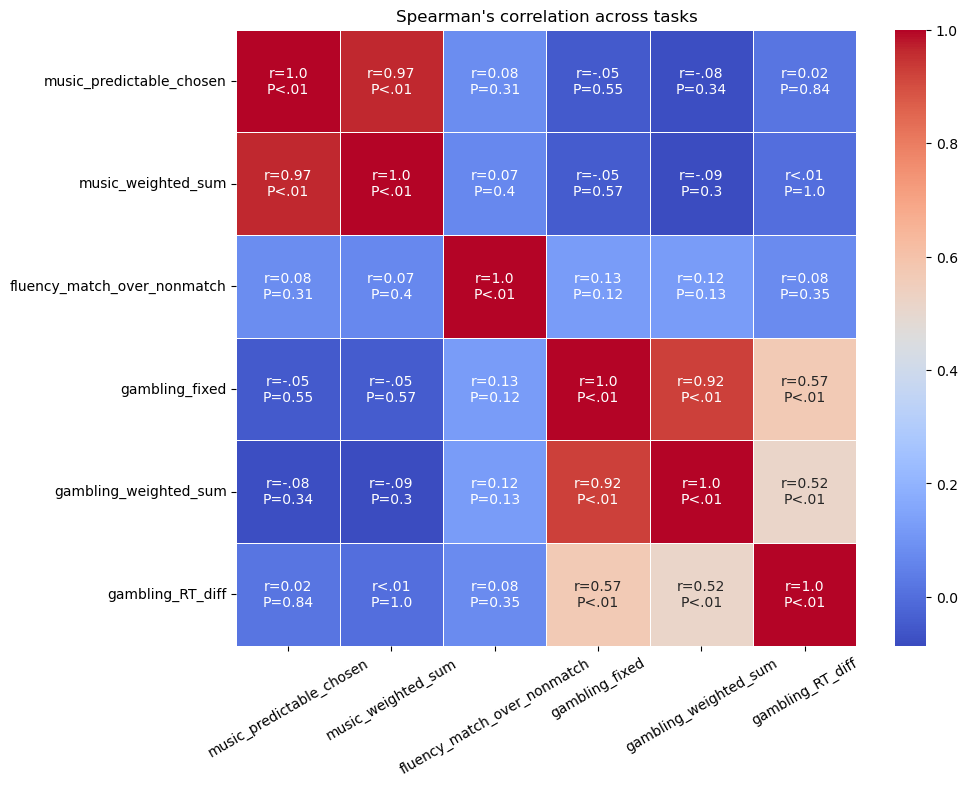

In [122]:
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

corr, pval = spearmanr(corr_data.values, nan_policy='omit')
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.title("Spearman's correlation across tasks")

# Save the plot
plt.savefig(f"./{RESULTS_FOLDER}/{ACROSS_TASKS}/Correlations_across_tasks_spearman.png")
plt.show()

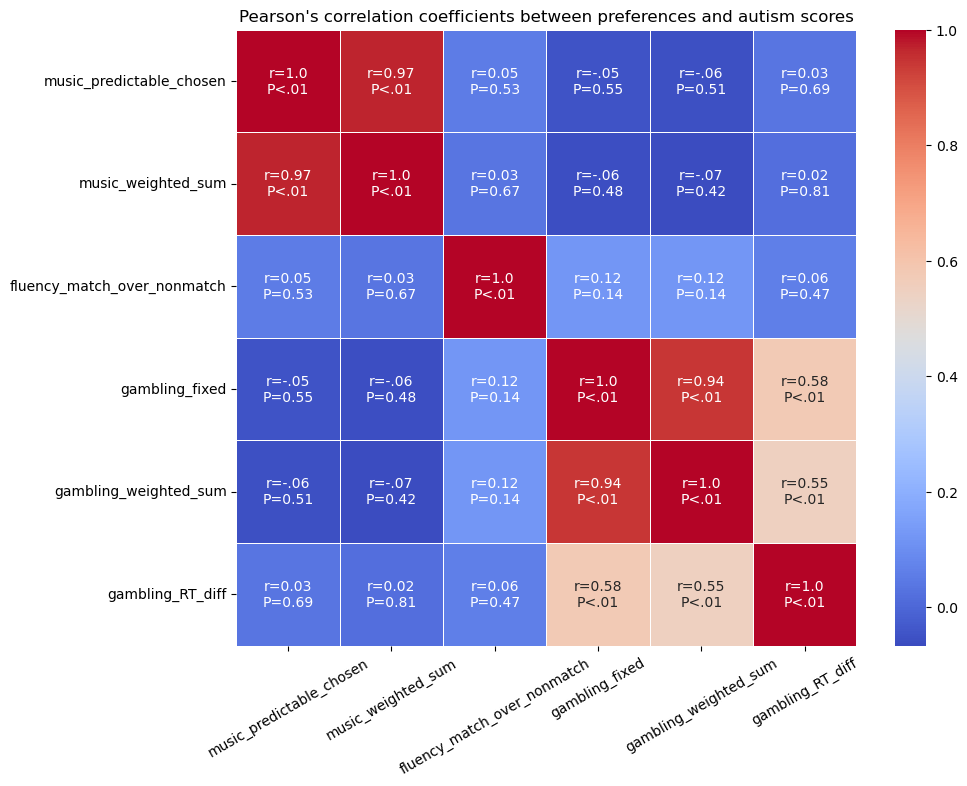

In [123]:
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')

# Initialize matrices to store correlation coefficients and p-values
corr = np.zeros((corr_data.shape[1], corr_data.shape[1]))
pval = np.zeros((corr_data.shape[1], corr_data.shape[1]))

# Calculate Pearson's correlation for each pair of variables
for i in range(corr_data.shape[1]):
    for j in range(corr_data.shape[1]):
        # Drop NA values for the pair of variables to mimic 'omit' policy
        subset = corr_data.iloc[:, [i, j]].dropna()
        if len(subset) > 1:  # Need at least 2 pairs to calculate correlation
            corr[i, j], pval[i, j] = pearsonr(subset.iloc[:, 0], subset.iloc[:, 1])
        else:
            corr[i, j], pval[i, j] = np.nan, np.nan
            
corr_df = pd.DataFrame(corr, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
cmap = color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap=cmap, cbar=True, linewidths=.5)
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.title("Pearson's correlation coefficients between preferences and autism scores")
# Save the plot
plt.savefig(f"./{RESULTS_FOLDER}/{ACROSS_TASKS}/Correlations_across_tasks_pearson.png")
plt.show()

In [ ]:
columns_to_use = list(range(4, 10)) + list(range(11, 17))  # Adjust indices as per your dataframe
corr_data = pd.concat([preference[['pref_pred']], questionnaire_data.iloc[:, columns_to_use]], axis=1)
corr_data = corr_data.apply(pd.to_numeric, errors='coerce')
corr_data.columns = ["predictable_seq_chosen", "AQ_total", "AQ_soc_skills", "AQ_att_switch", "AQ_att_detail", "AQ_comm", "AQ_imag", "SRS_total", "SRS_consc", "SRS_comm", "SRS_mot", "SRS_rig", "factorscores"]

# Calculate Spearman correlation and p-values
corr_matrix, pval_matrix = spearmanr(corr_data, nan_policy='omit')

# Create DataFrames for correlations and p-values
corr_df = pd.DataFrame(corr_matrix, index=corr_data.columns, columns=corr_data.columns)
pval_df = pd.DataFrame(pval_matrix, index=corr_data.columns, columns=corr_data.columns)

# Melt the correlation DataFrame and annotate
cordata = corr_df.stack().reset_index()
cordata.columns = ['X1', 'X2', 'value']
cordata['labelr'] = abbreviate_str(cordata['value'], 'r')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['labelP'] = abbreviate_str(pval_df.stack().reset_index()[0], 'P')
cordata['label'] = cordata['labelr'] + "\n" + cordata['labelP']

pivot_cordata = cordata.pivot(index='X1', columns='X2', values='label')
pivot_cordata = pivot_cordata.reindex(index=corr_df.index, columns=corr_df.columns)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_df, annot=pivot_cordata, fmt='', cmap='coolwarm', cbar=True, linewidths=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Spearman's correlation between music preference and autism subscores")
plt.tight_layout()

plt.savefig(f'{RESULTS_FOLDER}/{MUSIC_TASK}/Correlations_of_preferences_with_autism_subscores_spearman.png')
plt.show()